# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number :

## Student 1 
### Name :
### ID :

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [59]:
import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

In [60]:
# load the data
training_data = pd.read_csv('./SWaT_train.csv')
testing_data = pd.read_csv('./SWaT_test.csv')

training_signals = training_data.drop(columns=[' Timestamp', 'Normal/Attack'])
training_label = training_data['Normal/Attack']
training_label = np.where(training_label.to_numpy() == 'Normal', 0, 1)

testing_signals = testing_data.drop(columns=['Unnamed: 0', ' Timestamp', 'Normal/Attack'])
testing_label = testing_data['Normal/Attack']
testing_label = np.where(testing_label.to_numpy() == 'Normal', 0, 1)

training_data.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


## 2. LOF task – 1/2 A4 – Individual

In [61]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 2a. Plot LOF scores

In [62]:
# # uncomment it if you want to run it, but it is very time-consuming

# """
# The opposite LOF of the training samples. The higher, the more normal. 
# Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), 
# while outliers tend to have a larger LOF score.

# The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. 
# It is the average of the ratio of the local reachability density of a sample 
# and those of its k-nearest neighbors.
# """

# lofs = [] # for storing negative_outlier_factor_ score
# tpr = [] # for storing true positive rate
# fnr = [] # for storing false positive rate

# for nn in np.arange(1,121, 2):
#     lof = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
#                              metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
#     lof.fit(train_X)
#     lofs.append(lof.negative_outlier_factor_)

#     y_pred = lof.predict(test_X)
#     y_pred = y_pred == -1 # 0 <- -1, 0s/-1s are normal

#     tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
#     tpr.append(tp)
#     fnr.append(fn)
    
#     print(">" , end='')

In [63]:
tpr = np.loadtxt('./LOFtps.txt')
fnr = np.loadtxt('./LOFfns.txt')

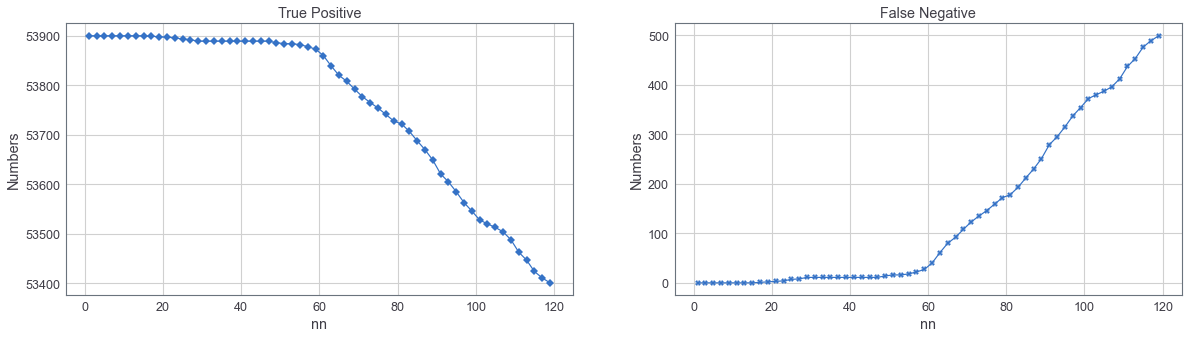

In [64]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(np.arange(1,121, 2), tpr, '-D')
plt.title('True Positive')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.subplot(122)
plt.plot(np.arange(1,121, 2), fnr, '-X')
plt.title('False Negative')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.show()

In [65]:
def compute_lof(data, signals, max_neighbours, test=0):  
    # Initialize data     
    lof_curvs = [ [] for _ in range(len(signals)) ]
    if test == 0:
        neighbour_array = range(1,max_neighbours)
    else:
        neighbour_array = range(max_neighbours, max_neighbours + 1)
    count_signal = 0
    lof_data = [ [] for _ in range(len(data['AIT201'])) ]
    
    # Compute LOF curve for each signal
    outliers = []
    for signal in signals:
        pref_lof = []
        outliers_index = {}
        data[signal] = np.random.permutation(data[signal].values)
        for i in range(len(data[signal])):
            lof_data[i] = [data[signal][i]]
        # Use the predefined number of neighbors         
        for n in neighbour_array:
            outliers_detected = 0
            # Apply LOF             
            clf = LocalOutlierFactor(n_neighbors=n)
            clf.fit_predict(lof_data)
            res = clf.negative_outlier_factor_
            count = 0
            for r in res:
                # Important threshold to define when a data point is a anomaly   
                if test == 1:
                    outliers_index[count] = r
                if r < -1.5 and test == 0:
                    outliers_detected += 1
                count += 1
            pref_lof.append(outliers_detected)
        outliers.append(outliers_index)
        # Save data         
        lof_curvs[count_signal] = pref_lof
        count_signal += 1
    if test == 1:
        return outliers
    return lof_curvs

In [66]:
def plot_lof(lof_curvs, signals, max_neighbours, title):
    f,ax = plt.subplots(figsize=(22,3))
    neighbour_array = range(1,max_neighbours)
    x = np.array(neighbour_array)
    count = 0
    for elem in lof_curvs:
        y = np.array(elem)
        # convert to pandas dataframe
        d = {'Number of neighbours used': x, 'Outliers detected': y}
        pd_data = pd.DataFrame(d)
        # plot using lineplot
        sns.set(style='darkgrid')
        ax.set_xticks(neighbour_array)
        ax.set_yscale('log')
        ax.set_title(title)
        g = sns.lineplot(x="Number of neighbours used", y="Outliers detected", data=pd_data, label=signals[count])
        count += 1

In [68]:
FIT_signals = ['FIT101','FIT201','FIT301','FIT401','FIT501','FIT502','FIT503','FIT504','FIT601']
LIT_signals = ['LIT101','LIT301','LIT401']
MV_signals = ['MV101','MV201','MV301','MV302','MV303','MV304']
P_signals = ['P101','P201','P203','P205','P302','P402','P403','P501','P601','P602','P603']
AIT_signals = ['AIT201','AIT202','AIT203','AIT401','AIT402','AIT501','AIT502','AIT503','AIT504']

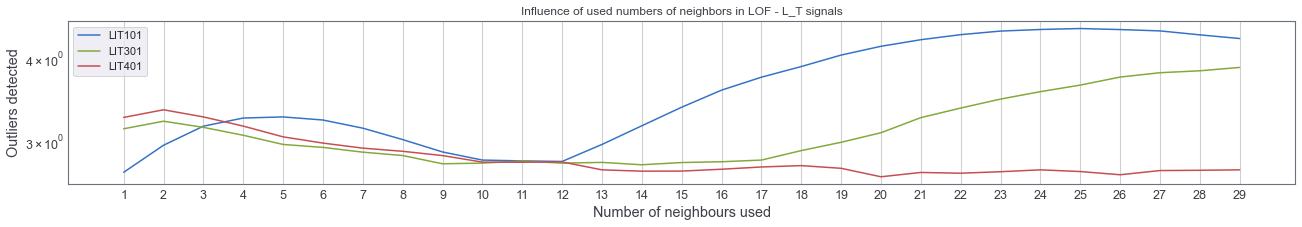

In [69]:
LIT_lof = np.loadtxt('./lofdata/LIT_lof.txt')
plot_lof(LIT_lof, LIT_signals, max_neighbours, "Influence of used numbers of neighbors in LOF - L_T signals")


In [70]:
# train for lof

In [71]:
max_neighbours = 30
MV_lof = compute_lof(train_X, MV_signals, max_neighbours)
plot_lof(MV_lof, MV_signals, max_neighbours, "Influence of used numbers of neighbors in LOF - MV signals")
np.savetxt('./lofdata/MV_lof.txt',MV_lof)

KeyboardInterrupt: 

### 2b. Analysis and answers to the questions